In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


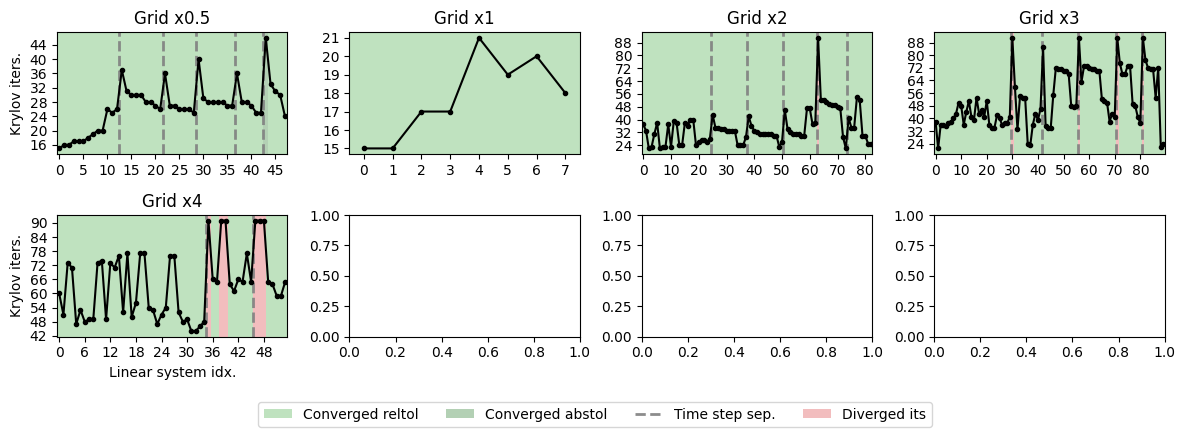

In [11]:
grid_refinement = [
    0.5,
    1,
    2,
    3,
    4,
    # 5,
    # 6,
    # 10,
    # 33,
]

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo0.3x{g}_sol{2}_ph{1}_bb{2}_fr{1}.json")
    names[i] = f"Grid x{g}"


shape = [2, 4]
figsize = (12, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

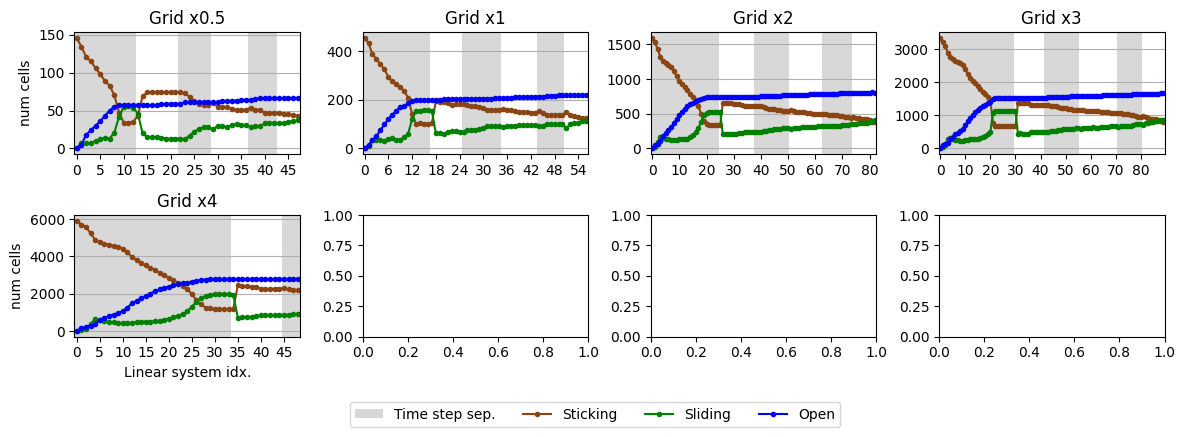

In [3]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [7]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 2


for g in grid_refinement:
    stats_name = f"stats_geo0.3x{g}_sol2_ph1_bb2_fr1.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = dofs_info["total dofs"]
    table["Total DoFs"].append(int(total_dofs))
    table["GMRES iters."].append(int(np.mean(get_gmres_iterations(entry))))
    table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))

    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,6461.0,29002.0,174668.0,540730.0
GMRES iters.,26.0,26.0,34.00,51.0
Newton iters.,8.0,9.5,13.83,15.0


In [8]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mandel_runscript_3 import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0.3,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.0, Dt: 1.75 (days)
sticking: 456, sliding: 0, open: 0


In [9]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 4
)

model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)



model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.ad_time_step.set_value(dt)
model.linear_system = mat, rhs
model.bmat.mat = mat


Sim time: 0.0, Dt: 1.75 (days)
sticking: 347, sliding: 34, open: 75


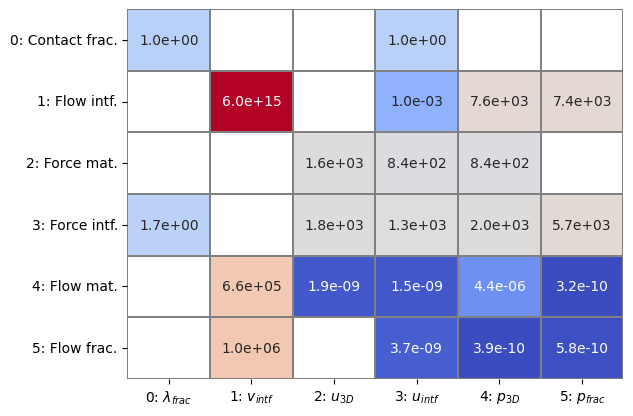

In [12]:
J = model.bmat[:]
J.plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 5.36
Solve  took: 2.45
True residual: 5.094785087817829e-09
PETSc Converged Reason: 2


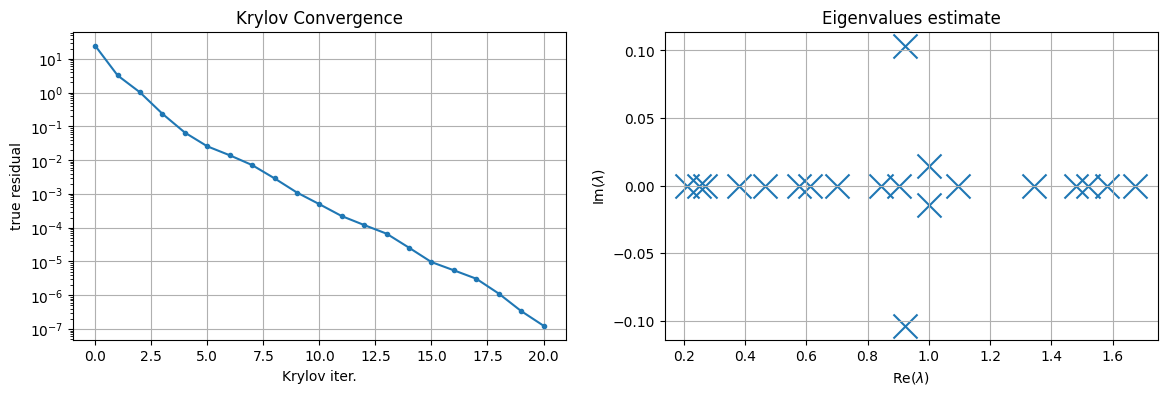

In [13]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

krylov = solve_petsc_3(
    J,
    rhs_global=rhs,
    return_data=True,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat, factor_levels=0),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat
                    * 1,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

tol, iters, levels
0.000005, 35, 4
0.00005,  21, 5

In [14]:
krylov.pc.getPythonContext().pc.S11_inv.S11_inv.J00_inv.pc.view()

PC Object: 1 MPI process
  type: gamg
    type is MULTIPLICATIVE, levels=4 cycles=v
      Cycles per PCApply=1
      Using externally compute Galerkin coarse grid matrices
      GAMG specific options
        Threshold for dropping small values in graph on each level =   5e-05   5e-05   5e-05   5e-05  
        Threshold scaling factor for each level not specified = 1.
        AGG specific options
          Number of levels of aggressive coarsening 0
          Number smoothing steps 1
        Complexity:    grid = 1.10027    operator = 1.212
  Coarse grid solver -- level 0 -------------------------------
    KSP Object: (mg_coarse_) 1 MPI process
      type: preonly
      maximum iterations=10000, initial guess is zero
      tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
      left preconditioning
      using NONE norm type for convergence test
    PC Object: (mg_coarse_) 1 MPI process
      type: bjacobi
        number of blocks = 1
        Local solver information for f